# 1. Import and Install Dependencies

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python mediapipe sklearn matplotlib

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

## Define methods

In [3]:
# Method for recognition
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR to RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [ ]:
# Start video capture from default webcam
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Stop when pressed 'q'
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [24]:
draw_landmarks(frame, results)

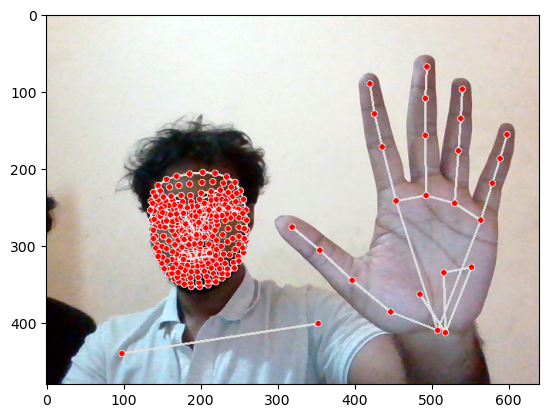

In [25]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [26]:
len(results.left_hand_landmarks.landmark)

21

In [27]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [28]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [31]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)

In [31]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [33]:
result_test = extract_keypoints(results)

In [34]:
result_test

array([ 0.30542043,  0.59780109, -0.56889623, ...,  0.        ,
        0.        ,  0.        ])

In [35]:
np.save('0', result_test)

In [36]:
np.load('0.npy')

array([ 0.30542043,  0.59780109, -0.56889623, ...,  0.        ,
        0.        ,  0.        ])

# 4. Setup Folders for Collection

In [11]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

In [51]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [57]:
cap = cv2.VideoCapture(0)
start_folder = 0
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [58]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [8]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [16]:
label_map = {label:num for num, label in enumerate(actions)}

In [17]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [18]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [63]:
np.array(sequences).shape

(90, 30, 1662)

In [64]:
np.array(labels).shape

(90,)

In [19]:
X = np.array(sequences)

In [66]:
X.shape

(90, 30, 1662)

In [20]:
y = tf.keras.utils.to_categorical(labels).astype(int)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [69]:
y_test.shape

(5, 3)

# 7. Build and Train LSTM Neural Network

In [71]:
log_dir = os.path.join('Logs')
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [12]:
# Define network architecture
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(tf.keras.layers.LSTM(128, return_sequences=True, activation='relu'))
model.add(tf.keras.layers.LSTM(64, return_sequences=False, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(actions.shape[0], activation='softmax'))

In [23]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [85]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 2s 57ms/step - loss: 1.3717 - categorical_accuracy: 0.3412
Epoch 2/2000
3/3 [==============================] - 0s 52ms/step - loss: 3.9667 - categorical_accuracy: 0.3294
Epoch 3/2000
3/3 [==============================] - 0s 53ms/step - loss: 5.4107 - categorical_accuracy: 0.3647
Epoch 4/2000
3/3 [==============================] - 0s 54ms/step - loss: 7.0509 - categorical_accuracy: 0.3176
Epoch 5/2000
3/3 [==============================] - 0s 54ms/step - loss: 9.2949 - categorical_accuracy: 0.3294
Epoch 6/2000
3/3 [==============================] - 0s 54ms/step - loss: 10.0744 - categorical_accuracy: 0.3412
Epoch 7/2000
3/3 [==============================] - 0s 54ms/step - loss: 6.4506 - categorical_accuracy: 0.2588
Epoch 8/2000
3/3 [==============================] - 0s 52ms/step - loss: 2.3354 - categorical_accuracy: 0.2706
Epoch 9/2000
3/3 [==============================] - 0s 58ms/step - loss: 2.5685 - categorical_accuracy: 0.2941


3/3 [==============================] - 0s 53ms/step - loss: 1.7611 - categorical_accuracy: 0.4588
Epoch 75/2000
3/3 [==============================] - 0s 50ms/step - loss: 1.5802 - categorical_accuracy: 0.3882
Epoch 76/2000
3/3 [==============================] - 0s 53ms/step - loss: 1.3050 - categorical_accuracy: 0.4588
Epoch 77/2000
3/3 [==============================] - 0s 54ms/step - loss: 1.0611 - categorical_accuracy: 0.4588
Epoch 78/2000
3/3 [==============================] - 0s 53ms/step - loss: 1.3751 - categorical_accuracy: 0.4118
Epoch 79/2000
3/3 [==============================] - 0s 53ms/step - loss: 1.4373 - categorical_accuracy: 0.3529
Epoch 80/2000
3/3 [==============================] - 0s 53ms/step - loss: 1.2253 - categorical_accuracy: 0.4471
Epoch 81/2000
3/3 [==============================] - 0s 51ms/step - loss: 1.3911 - categorical_accuracy: 0.3765
Epoch 82/2000
3/3 [==============================] - 0s 53ms/step - loss: 1.2498 - categorical_accuracy: 0.4118
Epoch 

3/3 [==============================] - 0s 55ms/step - loss: 0.6675 - categorical_accuracy: 0.6235
Epoch 147/2000
3/3 [==============================] - 0s 53ms/step - loss: 0.7631 - categorical_accuracy: 0.5529
Epoch 148/2000
3/3 [==============================] - 0s 51ms/step - loss: 0.6811 - categorical_accuracy: 0.6706
Epoch 149/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.7701 - categorical_accuracy: 0.5765
Epoch 150/2000
3/3 [==============================] - 0s 53ms/step - loss: 0.5730 - categorical_accuracy: 0.7176
Epoch 151/2000
3/3 [==============================] - 0s 52ms/step - loss: 0.8253 - categorical_accuracy: 0.6235
Epoch 152/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.6141 - categorical_accuracy: 0.7059
Epoch 153/2000
3/3 [==============================] - 0s 53ms/step - loss: 0.5188 - categorical_accuracy: 0.7294
Epoch 154/2000
3/3 [==============================] - 0s 50ms/step - loss: 0.5431 - categorical_accuracy: 0.694

3/3 [==============================] - 0s 53ms/step - loss: 0.5299 - categorical_accuracy: 0.7412
Epoch 219/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.5420 - categorical_accuracy: 0.7059
Epoch 220/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.5367 - categorical_accuracy: 0.7412
Epoch 221/2000
3/3 [==============================] - 0s 53ms/step - loss: 0.5418 - categorical_accuracy: 0.7529
Epoch 222/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.5212 - categorical_accuracy: 0.7765
Epoch 223/2000
3/3 [==============================] - 0s 52ms/step - loss: 0.5177 - categorical_accuracy: 0.7529
Epoch 224/2000
3/3 [==============================] - 0s 53ms/step - loss: 0.5193 - categorical_accuracy: 0.7529
Epoch 225/2000
3/3 [==============================] - 0s 51ms/step - loss: 0.5082 - categorical_accuracy: 0.7647
Epoch 226/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.5076 - categorical_accuracy: 0.776

3/3 [==============================] - 0s 53ms/step - loss: 0.4474 - categorical_accuracy: 0.7765
Epoch 291/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.3519 - categorical_accuracy: 0.8235
Epoch 292/2000
3/3 [==============================] - 0s 55ms/step - loss: 0.3794 - categorical_accuracy: 0.8235
Epoch 293/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.3892 - categorical_accuracy: 0.8353
Epoch 294/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.4005 - categorical_accuracy: 0.8118
Epoch 295/2000
3/3 [==============================] - 0s 51ms/step - loss: 0.3623 - categorical_accuracy: 0.8353
Epoch 296/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.3657 - categorical_accuracy: 0.8118
Epoch 297/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.3433 - categorical_accuracy: 0.8000
Epoch 298/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.3443 - categorical_accuracy: 0.847

3/3 [==============================] - 0s 54ms/step - loss: 0.2187 - categorical_accuracy: 0.8706
Epoch 363/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.2141 - categorical_accuracy: 0.9176
Epoch 364/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.2777 - categorical_accuracy: 0.8824
Epoch 365/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.2643 - categorical_accuracy: 0.8588
Epoch 366/2000
3/3 [==============================] - 0s 53ms/step - loss: 0.2616 - categorical_accuracy: 0.9059
Epoch 367/2000
3/3 [==============================] - 0s 51ms/step - loss: 0.3210 - categorical_accuracy: 0.8471
Epoch 368/2000
3/3 [==============================] - 0s 53ms/step - loss: 0.2540 - categorical_accuracy: 0.8941
Epoch 369/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.4490 - categorical_accuracy: 0.8235
Epoch 370/2000
3/3 [==============================] - 0s 56ms/step - loss: 0.5784 - categorical_accuracy: 0.752

3/3 [==============================] - 0s 62ms/step - loss: 0.1036 - categorical_accuracy: 0.9765
Epoch 435/2000
3/3 [==============================] - 0s 57ms/step - loss: 0.1374 - categorical_accuracy: 0.9176
Epoch 436/2000
3/3 [==============================] - 0s 62ms/step - loss: 0.1091 - categorical_accuracy: 0.9529
Epoch 437/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.1479 - categorical_accuracy: 0.9294
Epoch 438/2000
3/3 [==============================] - 0s 51ms/step - loss: 0.4639 - categorical_accuracy: 0.8118
Epoch 439/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.5856 - categorical_accuracy: 0.7647
Epoch 440/2000
3/3 [==============================] - 0s 61ms/step - loss: 0.4368 - categorical_accuracy: 0.8353
Epoch 441/2000
3/3 [==============================] - 0s 60ms/step - loss: 0.1882 - categorical_accuracy: 0.9294
Epoch 442/2000
3/3 [==============================] - 0s 55ms/step - loss: 0.2671 - categorical_accuracy: 0.894

3/3 [==============================] - 0s 52ms/step - loss: 0.0975 - categorical_accuracy: 0.9765
Epoch 507/2000
3/3 [==============================] - 0s 57ms/step - loss: 0.0946 - categorical_accuracy: 0.9765
Epoch 508/2000
3/3 [==============================] - 0s 55ms/step - loss: 0.0799 - categorical_accuracy: 0.9765
Epoch 509/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.0736 - categorical_accuracy: 0.9765
Epoch 510/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.0613 - categorical_accuracy: 0.9882
Epoch 511/2000
3/3 [==============================] - 0s 53ms/step - loss: 0.0699 - categorical_accuracy: 0.9765
Epoch 512/2000
3/3 [==============================] - 0s 52ms/step - loss: 0.0606 - categorical_accuracy: 0.9882
Epoch 513/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.0625 - categorical_accuracy: 0.9765
Epoch 514/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.0610 - categorical_accuracy: 0.988

3/3 [==============================] - 0s 54ms/step - loss: 0.3332 - categorical_accuracy: 0.9059
Epoch 579/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.2805 - categorical_accuracy: 0.8824
Epoch 580/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.2038 - categorical_accuracy: 0.9294
Epoch 581/2000
3/3 [==============================] - 0s 55ms/step - loss: 0.2805 - categorical_accuracy: 0.9059
Epoch 582/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.6029 - categorical_accuracy: 0.8353
Epoch 583/2000
3/3 [==============================] - 0s 53ms/step - loss: 0.2164 - categorical_accuracy: 0.9176
Epoch 584/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.2081 - categorical_accuracy: 0.9294
Epoch 585/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.2172 - categorical_accuracy: 0.9059
Epoch 586/2000
3/3 [==============================] - 0s 53ms/step - loss: 0.2807 - categorical_accuracy: 0.894

3/3 [==============================] - 0s 55ms/step - loss: 0.0063 - categorical_accuracy: 1.0000
Epoch 651/2000
3/3 [==============================] - 0s 55ms/step - loss: 0.0079 - categorical_accuracy: 1.0000
Epoch 652/2000
3/3 [==============================] - 0s 55ms/step - loss: 0.0059 - categorical_accuracy: 1.0000
Epoch 653/2000
3/3 [==============================] - 0s 55ms/step - loss: 0.0099 - categorical_accuracy: 1.0000
Epoch 654/2000
3/3 [==============================] - 0s 53ms/step - loss: 0.0051 - categorical_accuracy: 1.0000
Epoch 655/2000
3/3 [==============================] - 0s 55ms/step - loss: 0.0906 - categorical_accuracy: 0.9529
Epoch 656/2000
3/3 [==============================] - 0s 55ms/step - loss: 0.1733 - categorical_accuracy: 0.9529
Epoch 657/2000
3/3 [==============================] - 0s 55ms/step - loss: 0.4041 - categorical_accuracy: 0.9059
Epoch 658/2000
3/3 [==============================] - 0s 53ms/step - loss: 0.9122 - categorical_accuracy: 0.776

3/3 [==============================] - 0s 58ms/step - loss: 0.0106 - categorical_accuracy: 1.0000
Epoch 723/2000
3/3 [==============================] - 0s 56ms/step - loss: 0.0106 - categorical_accuracy: 1.0000
Epoch 724/2000
3/3 [==============================] - 0s 55ms/step - loss: 0.0106 - categorical_accuracy: 1.0000
Epoch 725/2000
3/3 [==============================] - 0s 52ms/step - loss: 0.0103 - categorical_accuracy: 1.0000
Epoch 726/2000
3/3 [==============================] - 0s 56ms/step - loss: 0.0102 - categorical_accuracy: 1.0000
Epoch 727/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.0098 - categorical_accuracy: 1.0000
Epoch 728/2000
3/3 [==============================] - 0s 53ms/step - loss: 0.0097 - categorical_accuracy: 1.0000
Epoch 729/2000
3/3 [==============================] - 0s 55ms/step - loss: 0.0094 - categorical_accuracy: 1.0000
Epoch 730/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.0098 - categorical_accuracy: 1.000

3/3 [==============================] - 0s 63ms/step - loss: 0.0026 - categorical_accuracy: 1.0000
Epoch 795/2000
3/3 [==============================] - 0s 58ms/step - loss: 0.0025 - categorical_accuracy: 1.0000
Epoch 796/2000
3/3 [==============================] - 0s 57ms/step - loss: 0.0023 - categorical_accuracy: 1.0000
Epoch 797/2000
3/3 [==============================] - 0s 69ms/step - loss: 0.0024 - categorical_accuracy: 1.0000
Epoch 798/2000
3/3 [==============================] - 0s 66ms/step - loss: 0.0024 - categorical_accuracy: 1.0000
Epoch 799/2000
3/3 [==============================] - 0s 54ms/step - loss: 0.0022 - categorical_accuracy: 1.0000
Epoch 800/2000
3/3 [==============================] - 0s 52ms/step - loss: 0.0023 - categorical_accuracy: 1.0000
Epoch 801/2000
3/3 [==============================] - 0s 55ms/step - loss: 0.0022 - categorical_accuracy: 1.0000
Epoch 802/2000
3/3 [==============================] - 0s 71ms/step - loss: 0.0022 - categorical_accuracy: 1.000

Epoch 866/2000
3/3 [==============================] - 0s 54ms/step - loss: 7.9120e-04 - categorical_accuracy: 1.0000
Epoch 867/2000
3/3 [==============================] - 0s 58ms/step - loss: 7.6737e-04 - categorical_accuracy: 1.0000
Epoch 868/2000
3/3 [==============================] - 0s 65ms/step - loss: 7.9153e-04 - categorical_accuracy: 1.0000
Epoch 869/2000
3/3 [==============================] - 0s 54ms/step - loss: 7.6079e-04 - categorical_accuracy: 1.0000
Epoch 870/2000
3/3 [==============================] - 0s 52ms/step - loss: 7.4740e-04 - categorical_accuracy: 1.0000
Epoch 871/2000
3/3 [==============================] - 0s 69ms/step - loss: 7.3309e-04 - categorical_accuracy: 1.0000
Epoch 872/2000
3/3 [==============================] - 0s 58ms/step - loss: 7.2594e-04 - categorical_accuracy: 1.0000
Epoch 873/2000
3/3 [==============================] - 0s 58ms/step - loss: 7.1488e-04 - categorical_accuracy: 1.0000
Epoch 874/2000
3/3 [==============================] - 0s 57ms/st

3/3 [==============================] - 0s 54ms/step - loss: 3.8189e-04 - categorical_accuracy: 1.0000
Epoch 937/2000
3/3 [==============================] - 0s 54ms/step - loss: 3.7302e-04 - categorical_accuracy: 1.0000
Epoch 938/2000
3/3 [==============================] - 0s 56ms/step - loss: 3.7613e-04 - categorical_accuracy: 1.0000
Epoch 939/2000
3/3 [==============================] - 0s 53ms/step - loss: 3.7183e-04 - categorical_accuracy: 1.0000
Epoch 940/2000
3/3 [==============================] - 0s 55ms/step - loss: 3.6692e-04 - categorical_accuracy: 1.0000
Epoch 941/2000
3/3 [==============================] - 0s 56ms/step - loss: 3.6433e-04 - categorical_accuracy: 1.0000
Epoch 942/2000
3/3 [==============================] - 0s 56ms/step - loss: 3.6206e-04 - categorical_accuracy: 1.0000
Epoch 943/2000
3/3 [==============================] - 0s 55ms/step - loss: 3.5303e-04 - categorical_accuracy: 1.0000
Epoch 944/2000
3/3 [==============================] - 0s 55ms/step - loss: 3.51

3/3 [==============================] - 0s 53ms/step - loss: 2.0206e-04 - categorical_accuracy: 1.0000
Epoch 1007/2000
3/3 [==============================] - 0s 67ms/step - loss: 2.0016e-04 - categorical_accuracy: 1.0000
Epoch 1008/2000
3/3 [==============================] - 0s 59ms/step - loss: 1.9997e-04 - categorical_accuracy: 1.0000
Epoch 1009/2000
3/3 [==============================] - 0s 58ms/step - loss: 1.9782e-04 - categorical_accuracy: 1.0000
Epoch 1010/2000
3/3 [==============================] - 0s 57ms/step - loss: 1.9669e-04 - categorical_accuracy: 1.0000
Epoch 1011/2000
3/3 [==============================] - 0s 66ms/step - loss: 1.9481e-04 - categorical_accuracy: 1.0000
Epoch 1012/2000
3/3 [==============================] - 0s 57ms/step - loss: 1.9478e-04 - categorical_accuracy: 1.0000
Epoch 1013/2000
3/3 [==============================] - 0s 55ms/step - loss: 1.9275e-04 - categorical_accuracy: 1.0000
Epoch 1014/2000
3/3 [==============================] - 0s 54ms/step - lo

3/3 [==============================] - 0s 53ms/step - loss: 1.3129e-04 - categorical_accuracy: 1.0000
Epoch 1076/2000
3/3 [==============================] - 0s 55ms/step - loss: 1.3066e-04 - categorical_accuracy: 1.0000
Epoch 1077/2000
3/3 [==============================] - 0s 55ms/step - loss: 1.3046e-04 - categorical_accuracy: 1.0000
Epoch 1078/2000
3/3 [==============================] - 0s 56ms/step - loss: 1.3017e-04 - categorical_accuracy: 1.0000
Epoch 1079/2000
3/3 [==============================] - 0s 56ms/step - loss: 1.2843e-04 - categorical_accuracy: 1.0000
Epoch 1080/2000
3/3 [==============================] - 0s 56ms/step - loss: 1.2762e-04 - categorical_accuracy: 1.0000
Epoch 1081/2000
3/3 [==============================] - 0s 54ms/step - loss: 1.2650e-04 - categorical_accuracy: 1.0000
Epoch 1082/2000
3/3 [==============================] - 0s 57ms/step - loss: 1.2626e-04 - categorical_accuracy: 1.0000
Epoch 1083/2000
3/3 [==============================] - 0s 54ms/step - lo

3/3 [==============================] - 0s 56ms/step - loss: 9.2653e-05 - categorical_accuracy: 1.0000
Epoch 1145/2000
3/3 [==============================] - 0s 56ms/step - loss: 9.2330e-05 - categorical_accuracy: 1.0000
Epoch 1146/2000
3/3 [==============================] - 0s 57ms/step - loss: 9.2298e-05 - categorical_accuracy: 1.0000
Epoch 1147/2000
3/3 [==============================] - 0s 58ms/step - loss: 9.1517e-05 - categorical_accuracy: 1.0000
Epoch 1148/2000
3/3 [==============================] - 0s 56ms/step - loss: 9.1280e-05 - categorical_accuracy: 1.0000
Epoch 1149/2000
3/3 [==============================] - 0s 56ms/step - loss: 9.0999e-05 - categorical_accuracy: 1.0000
Epoch 1150/2000
3/3 [==============================] - 0s 56ms/step - loss: 9.0308e-05 - categorical_accuracy: 1.0000
Epoch 1151/2000
3/3 [==============================] - 0s 56ms/step - loss: 9.0043e-05 - categorical_accuracy: 1.0000
Epoch 1152/2000
3/3 [==============================] - 0s 55ms/step - lo

3/3 [==============================] - 0s 55ms/step - loss: 6.8595e-05 - categorical_accuracy: 1.0000
Epoch 1214/2000
3/3 [==============================] - 0s 55ms/step - loss: 6.8058e-05 - categorical_accuracy: 1.0000
Epoch 1215/2000
3/3 [==============================] - 0s 56ms/step - loss: 6.7701e-05 - categorical_accuracy: 1.0000
Epoch 1216/2000
3/3 [==============================] - 0s 56ms/step - loss: 6.7638e-05 - categorical_accuracy: 1.0000
Epoch 1217/2000
3/3 [==============================] - 0s 56ms/step - loss: 6.7142e-05 - categorical_accuracy: 1.0000
Epoch 1218/2000
3/3 [==============================] - 0s 58ms/step - loss: 6.6959e-05 - categorical_accuracy: 1.0000
Epoch 1219/2000
3/3 [==============================] - 0s 55ms/step - loss: 6.6808e-05 - categorical_accuracy: 1.0000
Epoch 1220/2000
3/3 [==============================] - 0s 55ms/step - loss: 6.6459e-05 - categorical_accuracy: 1.0000
Epoch 1221/2000
3/3 [==============================] - 0s 56ms/step - lo

3/3 [==============================] - 0s 56ms/step - loss: 5.1653e-05 - categorical_accuracy: 1.0000
Epoch 1283/2000
3/3 [==============================] - 0s 55ms/step - loss: 5.1472e-05 - categorical_accuracy: 1.0000
Epoch 1284/2000
3/3 [==============================] - 0s 56ms/step - loss: 5.1387e-05 - categorical_accuracy: 1.0000
Epoch 1285/2000
3/3 [==============================] - 0s 57ms/step - loss: 5.1019e-05 - categorical_accuracy: 1.0000
Epoch 1286/2000
3/3 [==============================] - 0s 56ms/step - loss: 5.0749e-05 - categorical_accuracy: 1.0000
Epoch 1287/2000
3/3 [==============================] - 0s 59ms/step - loss: 5.0613e-05 - categorical_accuracy: 1.0000
Epoch 1288/2000
3/3 [==============================] - 0s 56ms/step - loss: 5.0389e-05 - categorical_accuracy: 1.0000
Epoch 1289/2000
3/3 [==============================] - 0s 56ms/step - loss: 5.0250e-05 - categorical_accuracy: 1.0000
Epoch 1290/2000
3/3 [==============================] - 0s 56ms/step - lo

3/3 [==============================] - 0s 58ms/step - loss: 3.8895e-05 - categorical_accuracy: 1.0000
Epoch 1352/2000
3/3 [==============================] - 0s 55ms/step - loss: 3.8694e-05 - categorical_accuracy: 1.0000
Epoch 1353/2000
3/3 [==============================] - 0s 57ms/step - loss: 3.8530e-05 - categorical_accuracy: 1.0000
Epoch 1354/2000
3/3 [==============================] - 0s 57ms/step - loss: 3.8435e-05 - categorical_accuracy: 1.0000
Epoch 1355/2000
3/3 [==============================] - 0s 56ms/step - loss: 3.8272e-05 - categorical_accuracy: 1.0000
Epoch 1356/2000
3/3 [==============================] - 0s 55ms/step - loss: 3.8145e-05 - categorical_accuracy: 1.0000
Epoch 1357/2000
3/3 [==============================] - 0s 57ms/step - loss: 3.7919e-05 - categorical_accuracy: 1.0000
Epoch 1358/2000
3/3 [==============================] - 0s 55ms/step - loss: 3.7745e-05 - categorical_accuracy: 1.0000
Epoch 1359/2000
3/3 [==============================] - 0s 56ms/step - lo

3/3 [==============================] - 0s 55ms/step - loss: 2.9839e-05 - categorical_accuracy: 1.0000
Epoch 1421/2000
3/3 [==============================] - 0s 58ms/step - loss: 2.9726e-05 - categorical_accuracy: 1.0000
Epoch 1422/2000
3/3 [==============================] - 0s 57ms/step - loss: 2.9644e-05 - categorical_accuracy: 1.0000
Epoch 1423/2000
3/3 [==============================] - 0s 55ms/step - loss: 2.9546e-05 - categorical_accuracy: 1.0000
Epoch 1424/2000
3/3 [==============================] - 0s 57ms/step - loss: 2.9524e-05 - categorical_accuracy: 1.0000
Epoch 1425/2000
3/3 [==============================] - 0s 59ms/step - loss: 2.9340e-05 - categorical_accuracy: 1.0000
Epoch 1426/2000
3/3 [==============================] - 0s 56ms/step - loss: 2.9223e-05 - categorical_accuracy: 1.0000
Epoch 1427/2000
3/3 [==============================] - 0s 55ms/step - loss: 2.9120e-05 - categorical_accuracy: 1.0000
Epoch 1428/2000
3/3 [==============================] - 0s 57ms/step - lo

3/3 [==============================] - 0s 58ms/step - loss: 2.3555e-05 - categorical_accuracy: 1.0000
Epoch 1490/2000
3/3 [==============================] - 0s 57ms/step - loss: 2.3474e-05 - categorical_accuracy: 1.0000
Epoch 1491/2000
3/3 [==============================] - 0s 56ms/step - loss: 2.3372e-05 - categorical_accuracy: 1.0000
Epoch 1492/2000
3/3 [==============================] - 0s 57ms/step - loss: 2.3309e-05 - categorical_accuracy: 1.0000
Epoch 1493/2000
3/3 [==============================] - 0s 55ms/step - loss: 2.3311e-05 - categorical_accuracy: 1.0000
Epoch 1494/2000
3/3 [==============================] - 0s 56ms/step - loss: 2.3187e-05 - categorical_accuracy: 1.0000
Epoch 1495/2000
3/3 [==============================] - 0s 55ms/step - loss: 2.3076e-05 - categorical_accuracy: 1.0000
Epoch 1496/2000
3/3 [==============================] - 0s 55ms/step - loss: 2.3070e-05 - categorical_accuracy: 1.0000
Epoch 1497/2000
3/3 [==============================] - 0s 56ms/step - lo

3/3 [==============================] - 0s 58ms/step - loss: 1.8918e-05 - categorical_accuracy: 1.0000
Epoch 1559/2000
3/3 [==============================] - 0s 57ms/step - loss: 1.8867e-05 - categorical_accuracy: 1.0000
Epoch 1560/2000
3/3 [==============================] - 0s 64ms/step - loss: 1.8823e-05 - categorical_accuracy: 1.0000
Epoch 1561/2000
3/3 [==============================] - 0s 56ms/step - loss: 1.8771e-05 - categorical_accuracy: 1.0000
Epoch 1562/2000
3/3 [==============================] - 0s 58ms/step - loss: 1.8690e-05 - categorical_accuracy: 1.0000
Epoch 1563/2000
3/3 [==============================] - 0s 57ms/step - loss: 1.8634e-05 - categorical_accuracy: 1.0000
Epoch 1564/2000
3/3 [==============================] - 0s 55ms/step - loss: 1.8656e-05 - categorical_accuracy: 1.0000
Epoch 1565/2000
3/3 [==============================] - 0s 57ms/step - loss: 1.8496e-05 - categorical_accuracy: 1.0000
Epoch 1566/2000
3/3 [==============================] - 0s 55ms/step - lo

3/3 [==============================] - 0s 58ms/step - loss: 1.5466e-05 - categorical_accuracy: 1.0000
Epoch 1628/2000
3/3 [==============================] - 0s 56ms/step - loss: 1.5412e-05 - categorical_accuracy: 1.0000
Epoch 1629/2000
3/3 [==============================] - 0s 57ms/step - loss: 1.5360e-05 - categorical_accuracy: 1.0000
Epoch 1630/2000
3/3 [==============================] - 0s 56ms/step - loss: 1.5333e-05 - categorical_accuracy: 1.0000
Epoch 1631/2000
3/3 [==============================] - 0s 59ms/step - loss: 1.5280e-05 - categorical_accuracy: 1.0000
Epoch 1632/2000
3/3 [==============================] - 0s 55ms/step - loss: 1.5242e-05 - categorical_accuracy: 1.0000
Epoch 1633/2000
3/3 [==============================] - 0s 57ms/step - loss: 1.5175e-05 - categorical_accuracy: 1.0000
Epoch 1634/2000
3/3 [==============================] - 0s 56ms/step - loss: 1.5137e-05 - categorical_accuracy: 1.0000
Epoch 1635/2000
3/3 [==============================] - 0s 55ms/step - lo

3/3 [==============================] - 0s 58ms/step - loss: 1.2797e-05 - categorical_accuracy: 1.0000
Epoch 1697/2000
3/3 [==============================] - 0s 58ms/step - loss: 1.2761e-05 - categorical_accuracy: 1.0000
Epoch 1698/2000
3/3 [==============================] - 0s 55ms/step - loss: 1.2739e-05 - categorical_accuracy: 1.0000
Epoch 1699/2000
3/3 [==============================] - 0s 57ms/step - loss: 1.2694e-05 - categorical_accuracy: 1.0000
Epoch 1700/2000
3/3 [==============================] - 0s 57ms/step - loss: 1.2653e-05 - categorical_accuracy: 1.0000
Epoch 1701/2000
3/3 [==============================] - 0s 57ms/step - loss: 1.2624e-05 - categorical_accuracy: 1.0000
Epoch 1702/2000
3/3 [==============================] - 0s 56ms/step - loss: 1.2588e-05 - categorical_accuracy: 1.0000
Epoch 1703/2000
3/3 [==============================] - 0s 56ms/step - loss: 1.2568e-05 - categorical_accuracy: 1.0000
Epoch 1704/2000
3/3 [==============================] - 0s 54ms/step - lo

3/3 [==============================] - 0s 57ms/step - loss: 1.0731e-05 - categorical_accuracy: 1.0000
Epoch 1766/2000
3/3 [==============================] - 0s 56ms/step - loss: 1.0700e-05 - categorical_accuracy: 1.0000
Epoch 1767/2000
3/3 [==============================] - 0s 57ms/step - loss: 1.0661e-05 - categorical_accuracy: 1.0000
Epoch 1768/2000
3/3 [==============================] - 0s 56ms/step - loss: 1.0640e-05 - categorical_accuracy: 1.0000
Epoch 1769/2000
3/3 [==============================] - 0s 57ms/step - loss: 1.0603e-05 - categorical_accuracy: 1.0000
Epoch 1770/2000
3/3 [==============================] - 0s 55ms/step - loss: 1.0580e-05 - categorical_accuracy: 1.0000
Epoch 1771/2000
3/3 [==============================] - 0s 55ms/step - loss: 1.0563e-05 - categorical_accuracy: 1.0000
Epoch 1772/2000
3/3 [==============================] - 0s 54ms/step - loss: 1.0546e-05 - categorical_accuracy: 1.0000
Epoch 1773/2000
3/3 [==============================] - 0s 56ms/step - lo

3/3 [==============================] - 0s 59ms/step - loss: 9.0889e-06 - categorical_accuracy: 1.0000
Epoch 1835/2000
3/3 [==============================] - 0s 55ms/step - loss: 9.0706e-06 - categorical_accuracy: 1.0000
Epoch 1836/2000
3/3 [==============================] - 0s 57ms/step - loss: 9.0734e-06 - categorical_accuracy: 1.0000
Epoch 1837/2000
3/3 [==============================] - 0s 56ms/step - loss: 9.0131e-06 - categorical_accuracy: 1.0000
Epoch 1838/2000
3/3 [==============================] - 0s 56ms/step - loss: 8.9935e-06 - categorical_accuracy: 1.0000
Epoch 1839/2000
3/3 [==============================] - 0s 56ms/step - loss: 8.9767e-06 - categorical_accuracy: 1.0000
Epoch 1840/2000
3/3 [==============================] - 0s 57ms/step - loss: 8.9514e-06 - categorical_accuracy: 1.0000
Epoch 1841/2000
3/3 [==============================] - 0s 54ms/step - loss: 8.9290e-06 - categorical_accuracy: 1.0000
Epoch 1842/2000
3/3 [==============================] - 0s 56ms/step - lo

3/3 [==============================] - 0s 58ms/step - loss: 7.7272e-06 - categorical_accuracy: 1.0000
Epoch 1904/2000
3/3 [==============================] - 0s 57ms/step - loss: 7.7132e-06 - categorical_accuracy: 1.0000
Epoch 1905/2000
3/3 [==============================] - 0s 56ms/step - loss: 7.6964e-06 - categorical_accuracy: 1.0000
Epoch 1906/2000
3/3 [==============================] - 0s 56ms/step - loss: 7.6739e-06 - categorical_accuracy: 1.0000
Epoch 1907/2000
3/3 [==============================] - 0s 57ms/step - loss: 7.6585e-06 - categorical_accuracy: 1.0000
Epoch 1908/2000
3/3 [==============================] - 0s 56ms/step - loss: 7.6403e-06 - categorical_accuracy: 1.0000
Epoch 1909/2000
3/3 [==============================] - 0s 55ms/step - loss: 7.6248e-06 - categorical_accuracy: 1.0000
Epoch 1910/2000
3/3 [==============================] - 0s 56ms/step - loss: 7.6024e-06 - categorical_accuracy: 1.0000
Epoch 1911/2000
3/3 [==============================] - 0s 57ms/step - lo

3/3 [==============================] - 0s 58ms/step - loss: 6.6095e-06 - categorical_accuracy: 1.0000
Epoch 1973/2000
3/3 [==============================] - 0s 57ms/step - loss: 6.5927e-06 - categorical_accuracy: 1.0000
Epoch 1974/2000
3/3 [==============================] - 0s 56ms/step - loss: 6.5787e-06 - categorical_accuracy: 1.0000
Epoch 1975/2000
3/3 [==============================] - 0s 56ms/step - loss: 6.5661e-06 - categorical_accuracy: 1.0000
Epoch 1976/2000
3/3 [==============================] - 0s 55ms/step - loss: 6.5577e-06 - categorical_accuracy: 1.0000
Epoch 1977/2000
3/3 [==============================] - 0s 58ms/step - loss: 6.5408e-06 - categorical_accuracy: 1.0000
Epoch 1978/2000
3/3 [==============================] - 0s 58ms/step - loss: 6.5352e-06 - categorical_accuracy: 1.0000
Epoch 1979/2000
3/3 [==============================] - 0s 56ms/step - loss: 6.5114e-06 - categorical_accuracy: 1.0000
Epoch 1980/2000
3/3 [==============================] - 0s 58ms/step - lo

In [86]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-tr

# 8. Make Predictions

In [87]:
res = model.predict(X_test)

1/1 [==============================] - 0s 231ms/step


In [88]:
actions[np.argmax(res[4])]

'iloveyou'

In [89]:
actions[np.argmax(y_test[4])]

'thanks'

# 9. Save Weights

In [90]:
model.save('action.h5')

In [80]:
del model

In [24]:
model.load_weights('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [14]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [25]:
# evaluate test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"loss : {loss}\nAccuracy : {accuracy}")

1/1 [==============================] - 4s 4s/step - loss: 1.0490e-06 - categorical_accuracy: 1.0000
loss : 1.0490400654816767e-06
Accuracy : 1.0


In [94]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 24ms/step


In [95]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [96]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[3., 1.],
        [1., 0.]],

       [[1., 1.],
        [3., 0.]],

       [[1., 3.],
        [1., 0.]]])

In [97]:
accuracy_score(ytrue, yhat)

0.0

# 11. Test in Real Time

In [98]:
from scipy import stats

In [28]:
colors_list = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        if num > 2 :
            num = 2
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

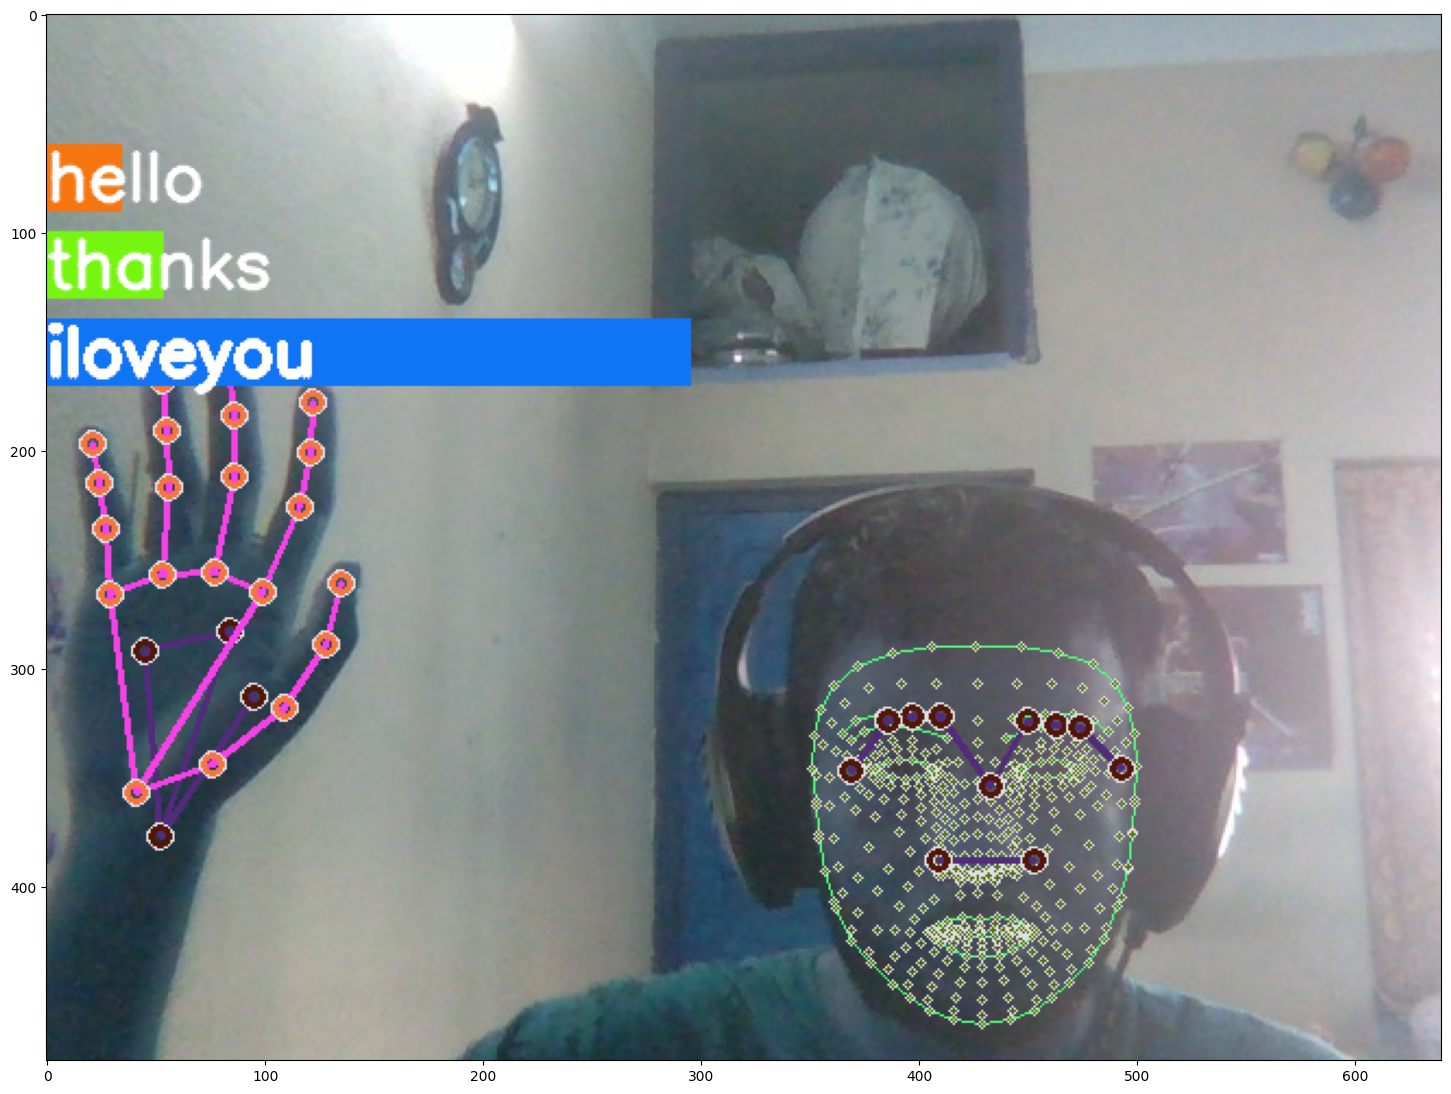

In [29]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors_list))

In [32]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors_list)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 6s 6s/step
thanks
1/1 [==============================] - 0s 138ms/step
thanks
1/1 [==============================] - 0s 91ms/step
thanks
1/1 [==============================] - 2s 2s/step
thanks
1/1 [==============================] - 2s 2s/step
thanks
1/1 [==============================] - 0s 117ms/step
thanks
1/1 [==============================] - 0s 75ms/step
thanks
1/1 [==============================] - 0s 75ms/step
thanks
1/1 [==============================] - 0s 74ms/step
thanks
1/1 [==============================] - 0s 80ms/step
thanks
1/1 [==============================] - 0s 83ms/step
thanks
1/1 [==============================] - 0s 77ms/step
thanks
1/1 [==============================] - 0s 93ms/step
thanks
1/1 [==============================] - 0s 103ms/step
thanks
1/1 [==============================] - 0s 90ms/step
thanks
1/1 [==============================] - 0s 93ms/step
thanks
1/1 [==============================] - 0s 85ms/step
thanks
